# Load the data

We will load the Amazon reviews from 5 channels

In [1]:
import pandas as pd
from glob import glob

files = glob("../../data/*")
print(files)

['../../data/Appliances.jsonl.gz', '../../data/Amazon_Fashion.jsonl.gz', '../../data/All_Beauty.jsonl.gz']


In [2]:
df0 = pd.read_json(files[0], lines=True )
df0 = df0[['rating', 'text']]
df0['cat'] = files[0].split('.')[-3].split('/')[-1]
df1 = pd.read_json(files[1], lines=True )
df1 = df1[['rating', 'text']]
df1['cat'] = files[1].split('.')[-3].split('/')[-1]
df2 = pd.read_json(files[2], lines=True )
df2 = df2[['rating', 'text']]
df2['cat'] = files[2].split('.')[-3].split('/')[-1]

df = pd.concat([df0, df1, df2])

del df0, df1, df2

print(df.shape)
display(df.head())

(5331072, 3)


rating                                               text         cat
0       5              work great. use a new one every month  Appliances
1       5                            Little on the thin side  Appliances
2       5                   Quick delivery, fixed the issue!  Appliances
3       5  I wasn't sure whether these were worth it or n...  Appliances
4       5  Easy to install got the product expected to re...  Appliances

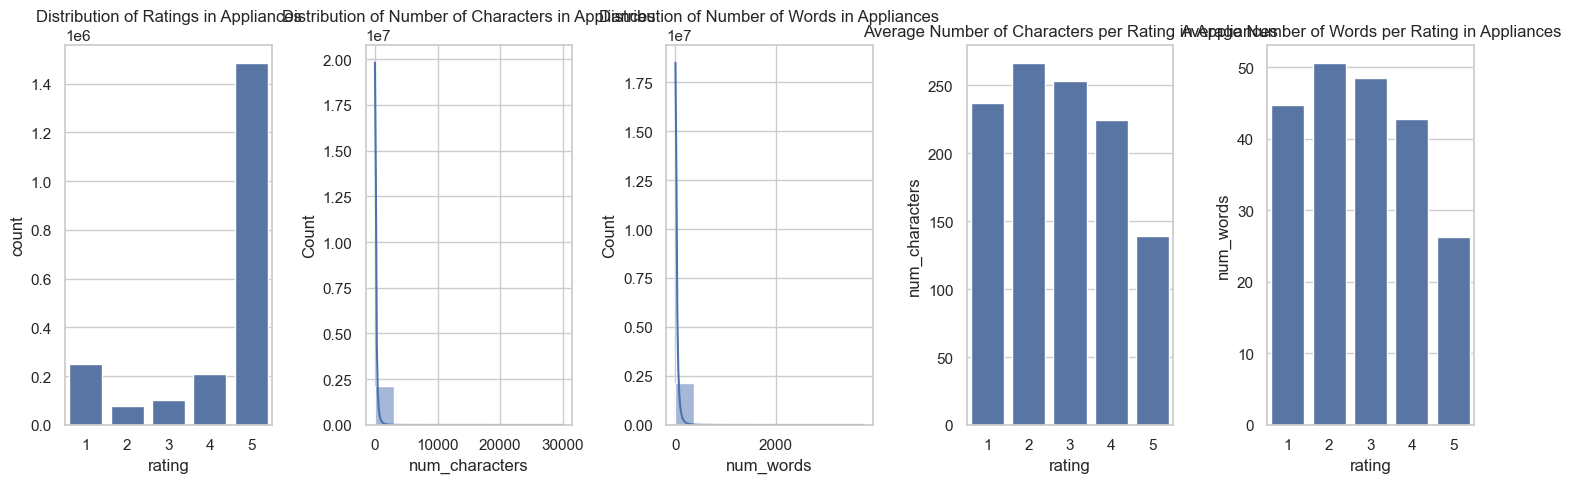

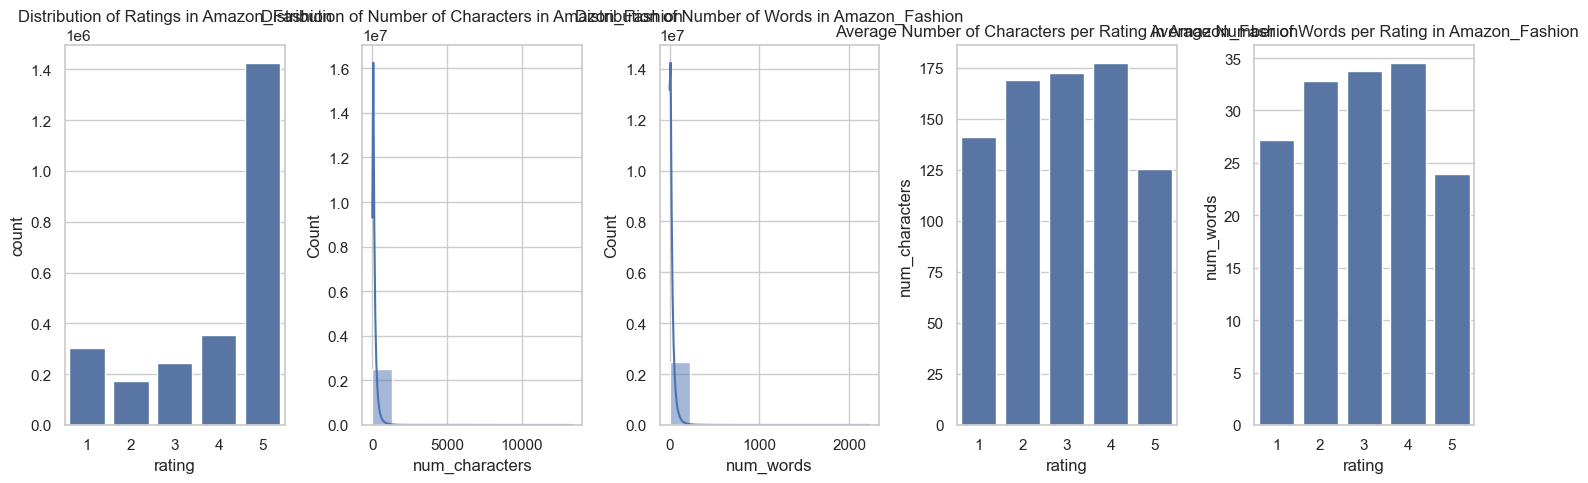

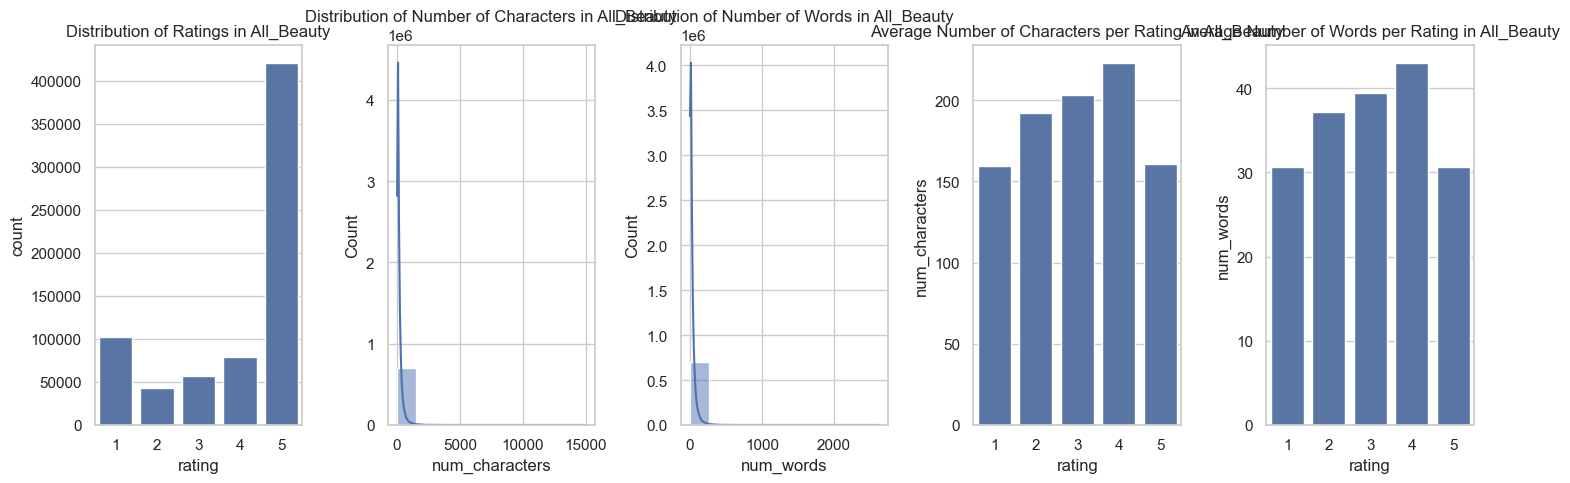

In [3]:
df['num_characters'] = [len(t) for t in df.text.values]
df['num_words'] = [len(t.split(' ')) for t in df.text.values]

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# For each category, the distribution of ratings, number of characters, and number of words
categories = df['cat'].unique()

for category in categories:
    subset = df[df['cat'] == category]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 5, 1)
    sns.countplot(x='rating', data=subset)
    plt.title(f'Distribution of Ratings in {category}')
    
    plt.subplot(1, 5, 2)
    sns.histplot(subset['num_characters'], bins=10, kde=True)
    plt.title(f'Distribution of Number of Characters in {category}')
    
    plt.subplot(1, 5, 3)
    sns.histplot(subset['num_words'], bins=10, kde=True)
    plt.title(f'Distribution of Number of Words in {category}')

    plt.subplot(1, 5, 4) 
    sns.barplot(x='rating', y='num_characters', data=subset, errorbar=None) 
    plt.title(f'Average Number of Characters per Rating in {category}') 
    
    plt.subplot(1, 5, 5) 
    sns.barplot(x='rating', y='num_words', data=subset, errorbar=None) 
    plt.title(f'Average Number of Words per Rating in {category}')
    
    plt.tight_layout()
    plt.show()



*Some findings here*:
1. Ratings 2 and 3 are the most few ratings, 
2. They are also the ones with the most number of characters and words
3. Rating 5 is the most frequent rating in all categories, but has the least amount of word and character count

Start cleaning the review texts


  0%|          | 0/5331072 [00:00<?, ?it/s][nltk_data] Downloading package punkt_tab to /Users/mrla/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mrla/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /Users/mrla/nltk_data...
[nltk_data] Downloading package punkt_tab to /Users/mrla/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mrla/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mrla/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-


Done cleaning the review texts


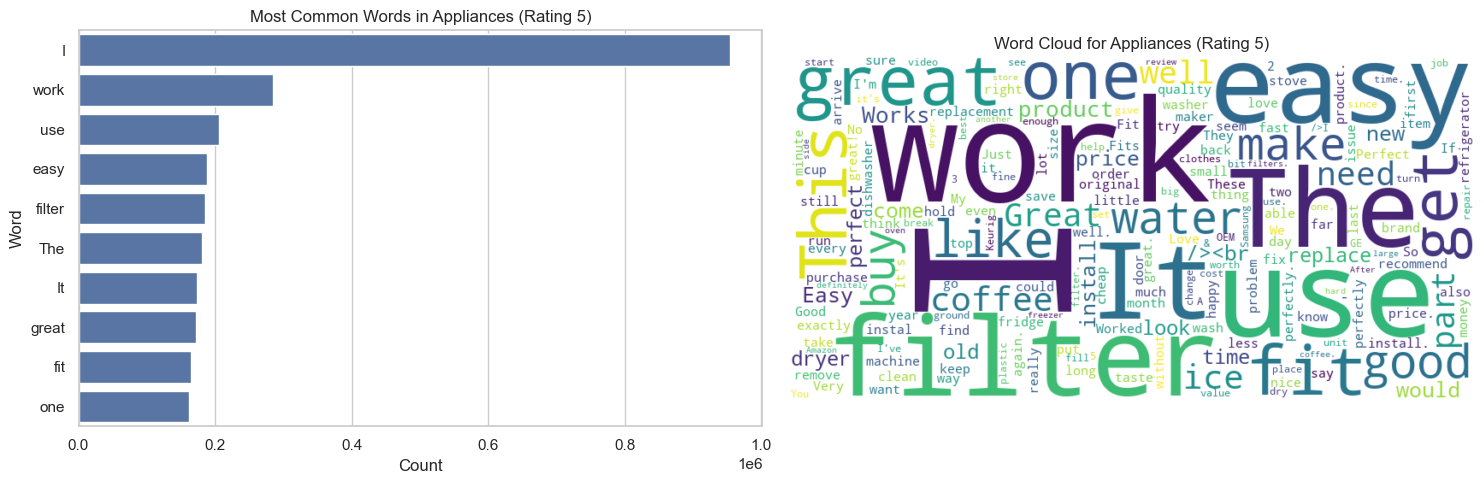

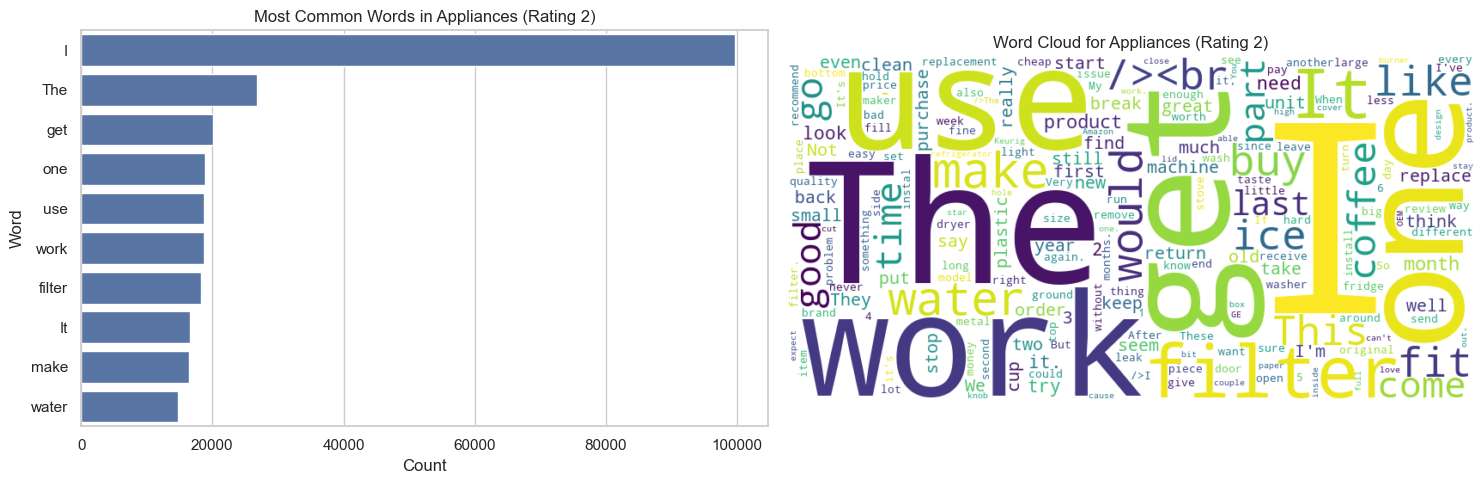

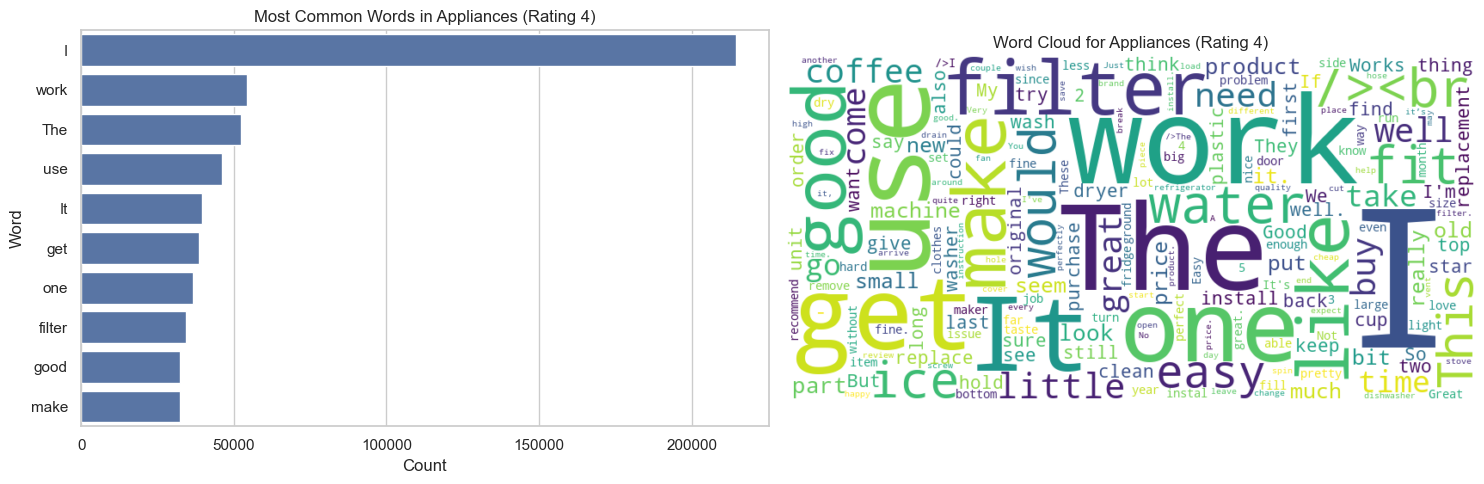

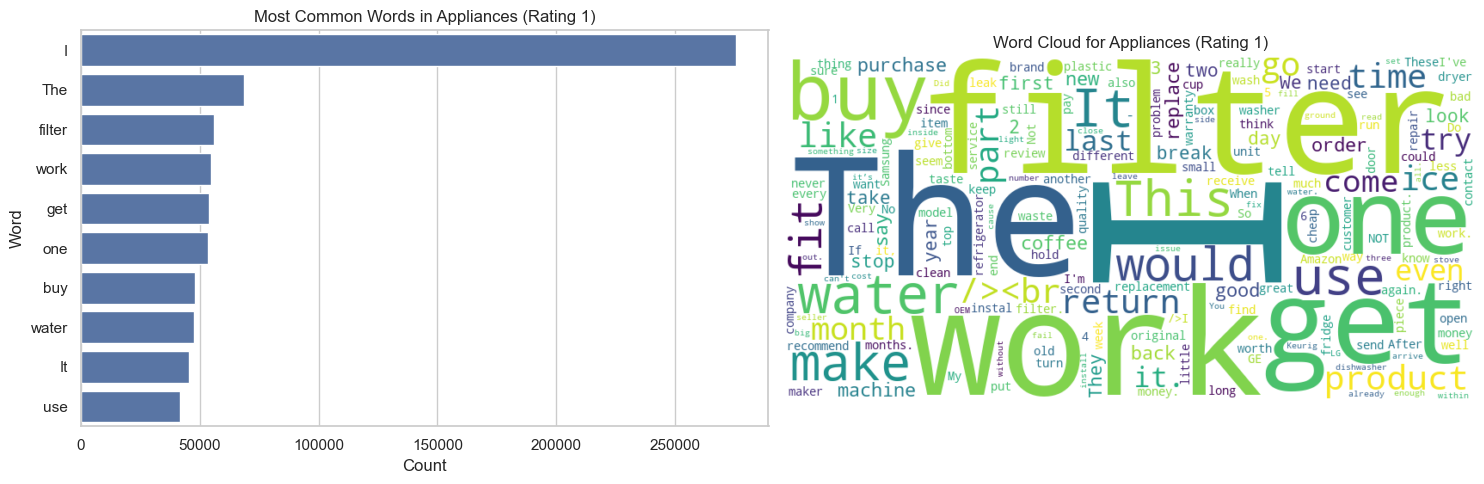

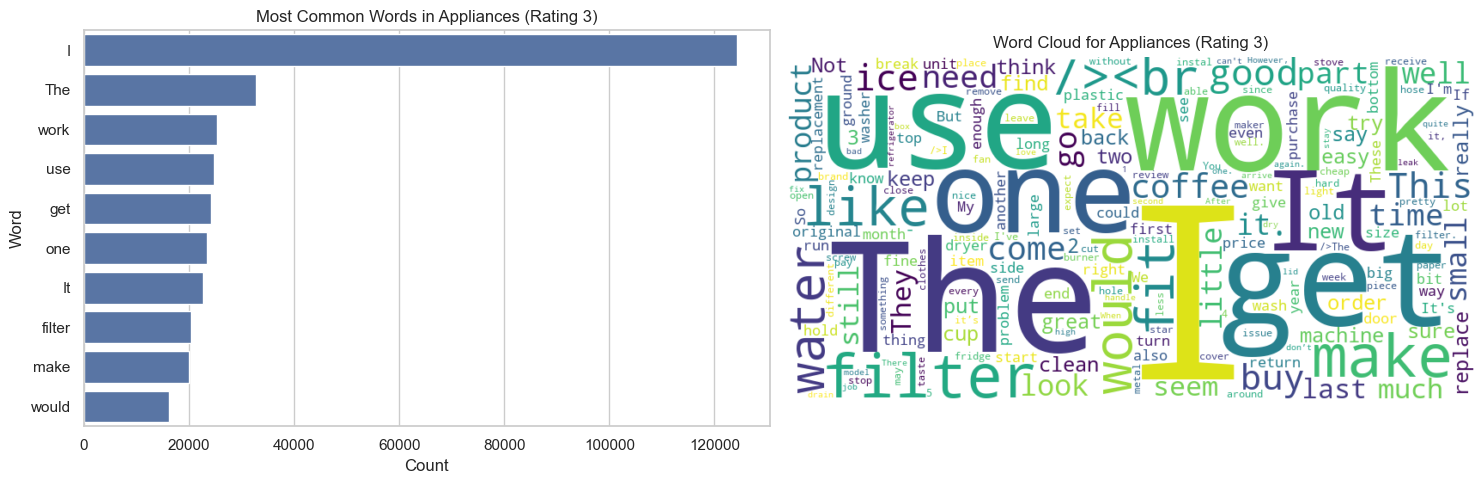

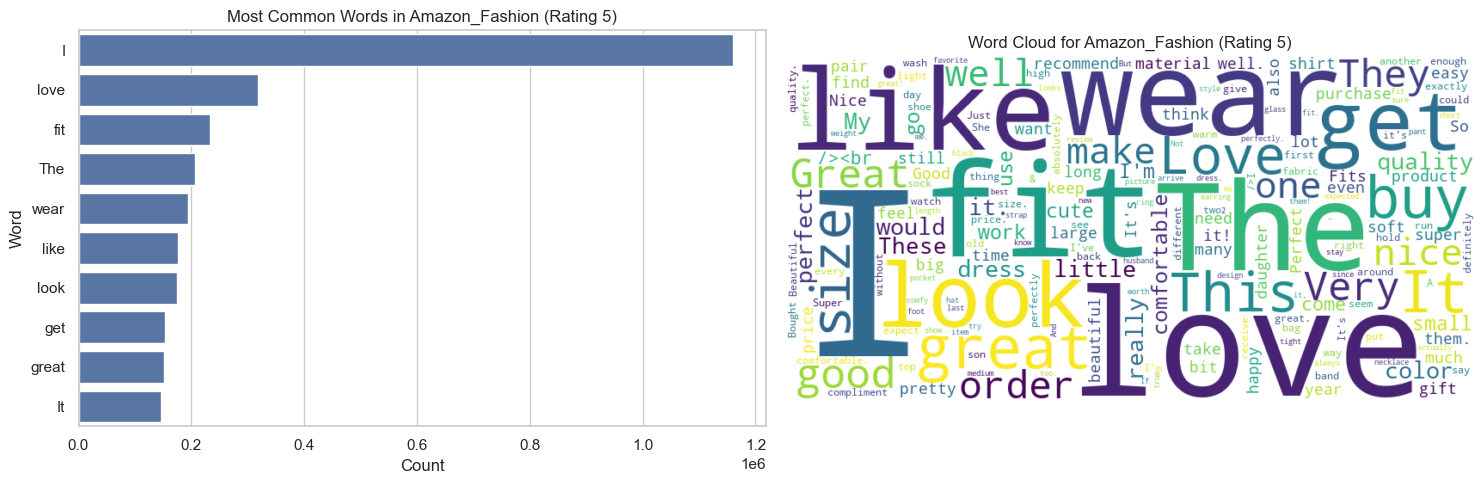

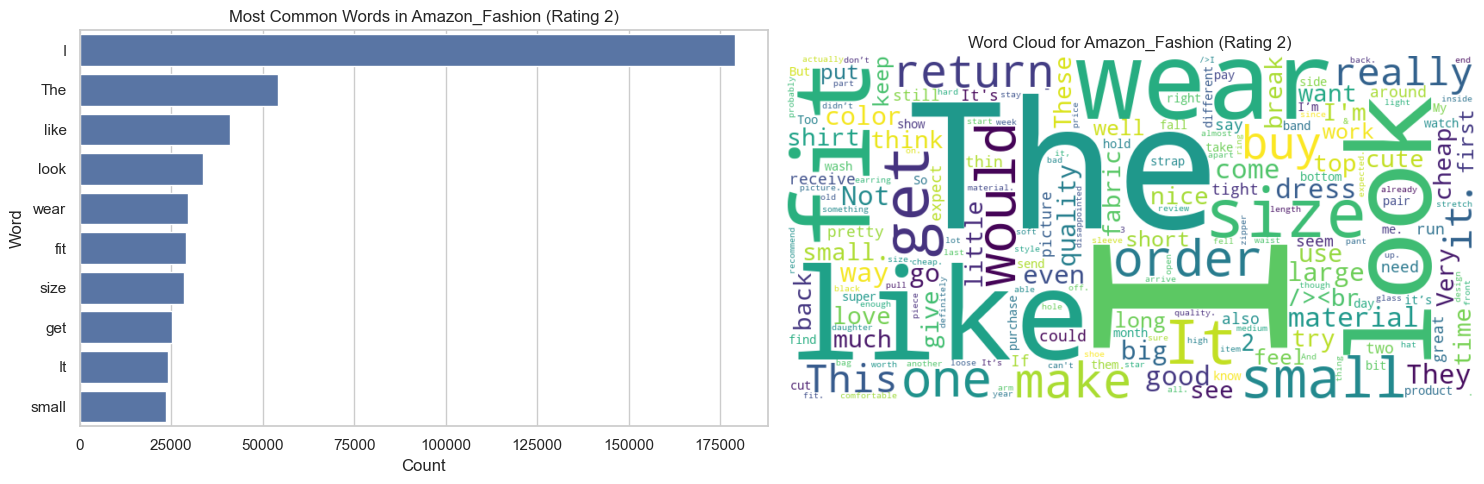

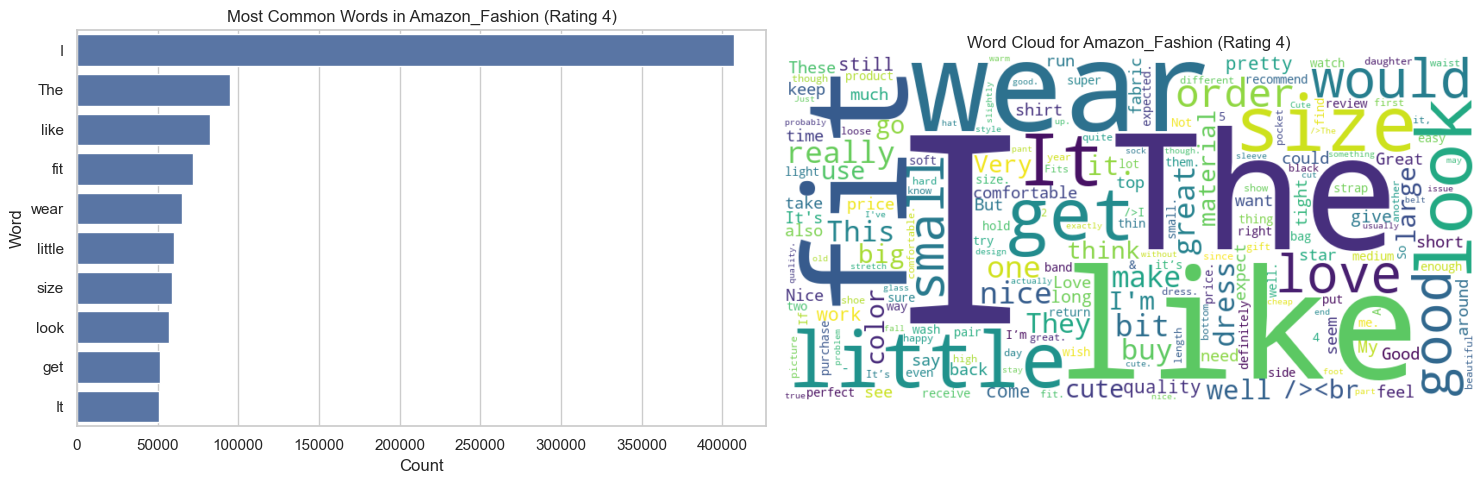

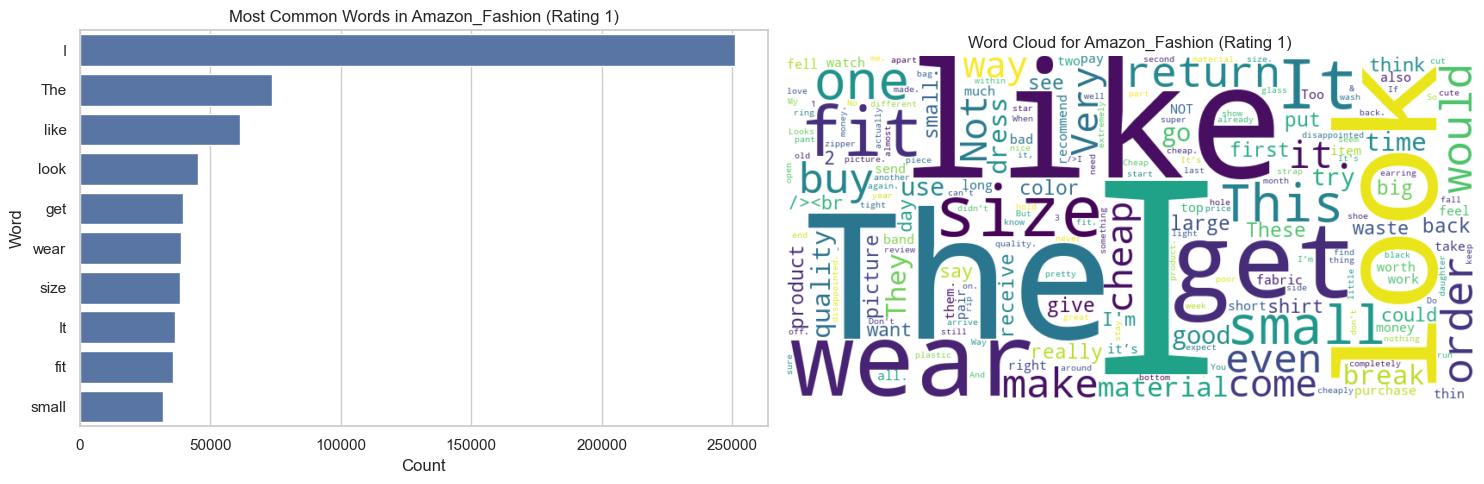

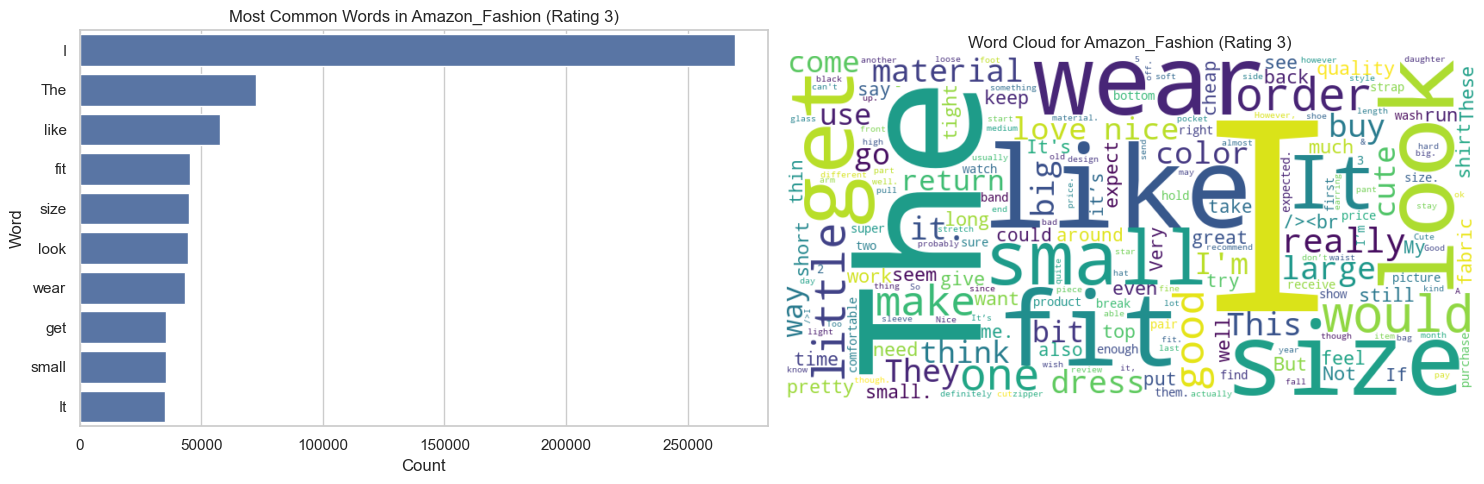

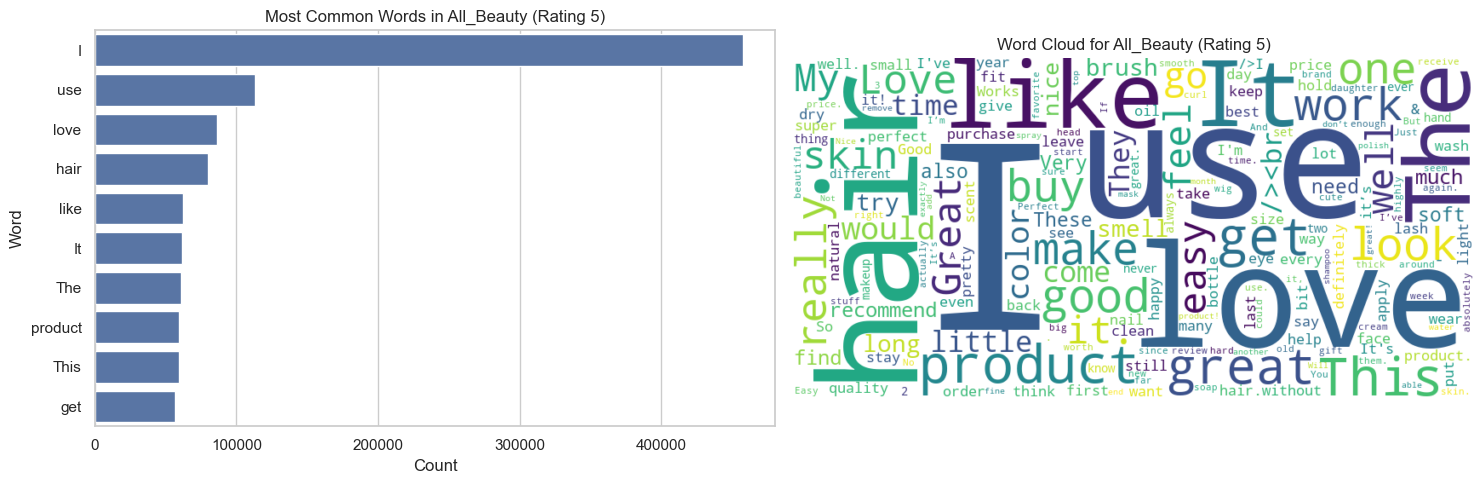

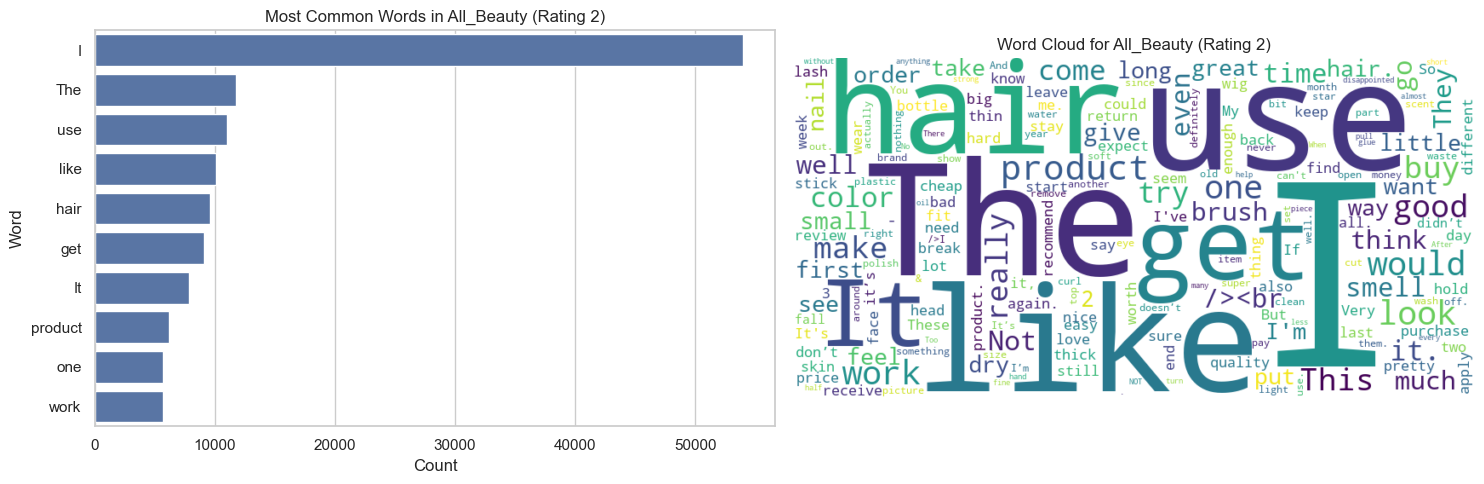

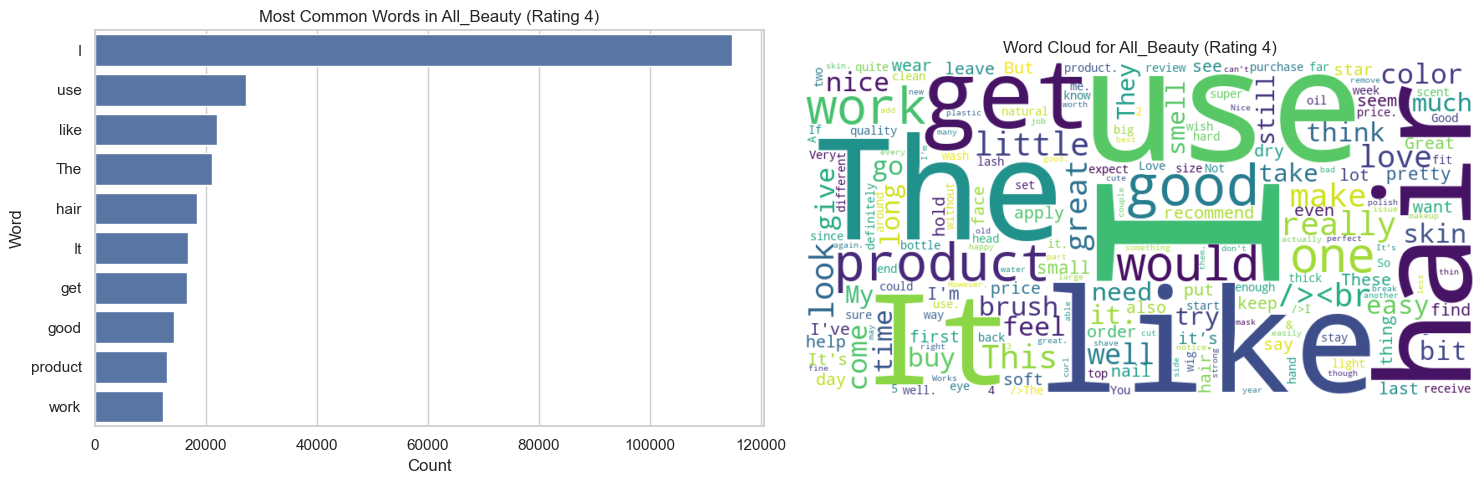

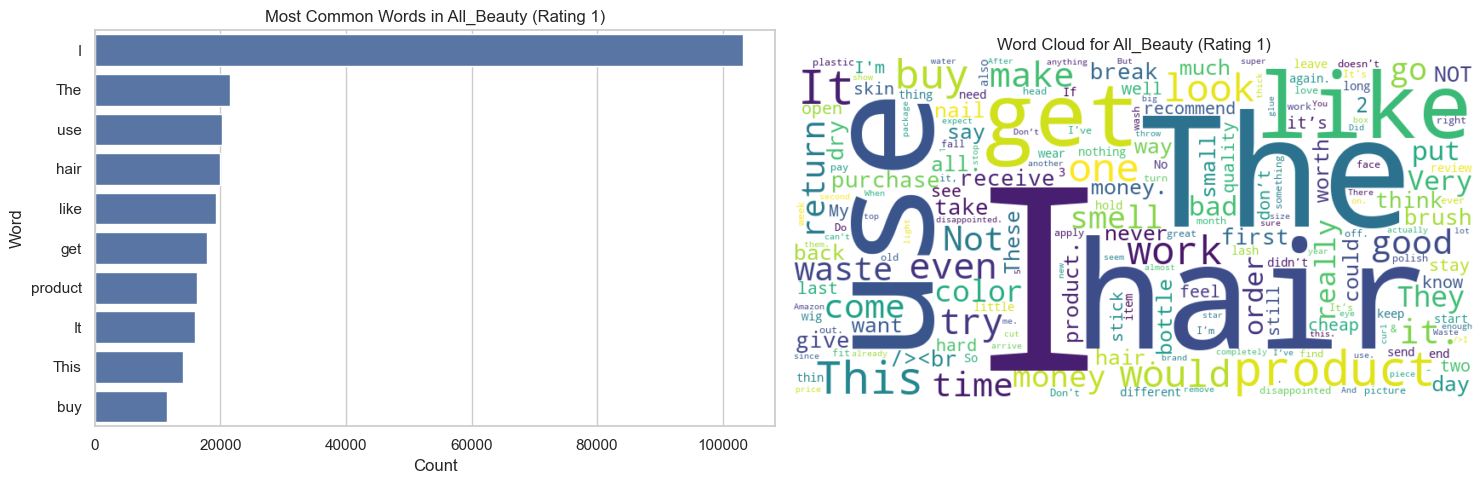

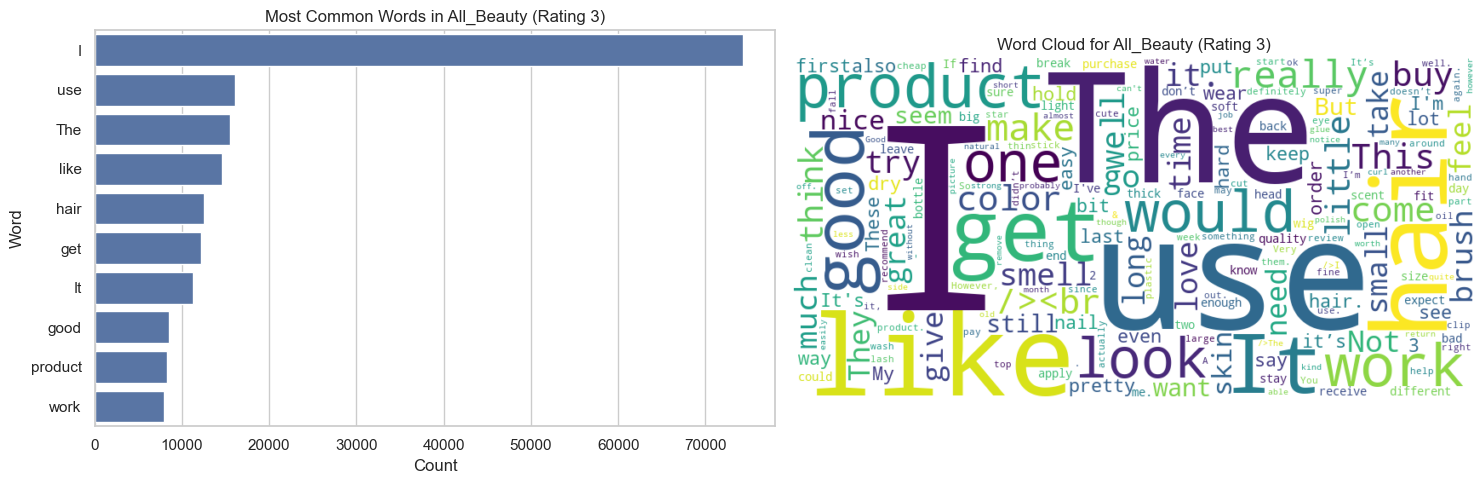

In [27]:
from tqdm import tqdm
from multiprocessing import Pool
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from text_lemmatizer_mp import preprocess_text

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# nltk.download('wordnet')

# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# from nltk import pos_tag, word_tokenize

# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return None

# lemmatizer = WordNetLemmatizer()

# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')

# def preprocess_text(text):
#     # tokens = word_tokenize(text)
#     tokens = text.split()
#     tagged = pos_tag(tokens)
#     lemmatized_sentence = []
    
#     lemmatized_sentence = [
#         lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag) or wordnet.NOUN)
#         for word, tag in tagged if word not in stop_words
#     ]
#     return lemmatized_sentence

def parallel_preprocess_texts(texts): 
    with Pool() as pool: 
        return list(tqdm(pool.imap(preprocess_text, texts), total=len(texts)))

categories = df['cat'].unique()
ratings = df['rating'].unique()

print("Start cleaning the review texts")

df['text_clean'] = parallel_preprocess_texts(df['text'].values)
# df['text_clean'] = [preprocess_text(t) for t in tqdm(df['text'].values, desc="Cleaning review texts")]

print("Done cleaning the review texts")

for category in categories:
    for rating in ratings:
        subset = df[(df['cat'] == category) & (df['rating'] == rating)]
        all_words = []
        for review_words in subset['text_clean']:
            all_words.extend(review_words)
        
        word_counts = Counter(all_words)
        common_words = word_counts.most_common(10)
        
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Bar Chart
        words, counts = zip(*common_words)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0])
        axes[0].set_title(f'Most Common Words in {category} (Rating {rating})')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Word')
        
        # Word Cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        axes[1].imshow(wordcloud, interpolation='bilinear')
        axes[1].set_title(f'Word Cloud for {category} (Rating {rating})')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()


In [28]:
df.head()

rating                                               text         cat  \
0       5              work great. use a new one every month  Appliances   
1       5                            Little on the thin side  Appliances   
2       5                   Quick delivery, fixed the issue!  Appliances   
3       5  I wasn't sure whether these were worth it or n...  Appliances   
4       5  Easy to install got the product expected to re...  Appliances   

   num_characters  num_words  \
0              37          8   
1              23          5   
2              32          5   
3             299         57   
4              51          9   

                                          text_clean  
0        [work, great., use, new, one, every, month]  
1                               [Little, thin, side]  
2                    [Quick, delivery,, fix, issue!]  
3  [I, sure, whether, worth, not,, give, cost, co...  
4     [Easy, install, get, product, expect, receive]

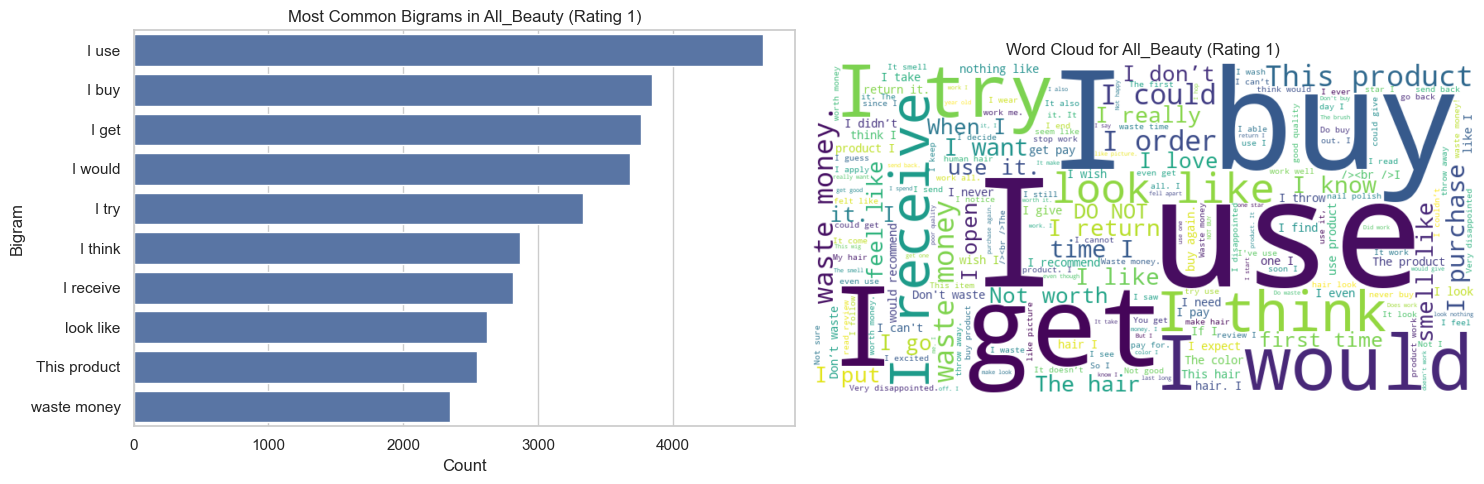

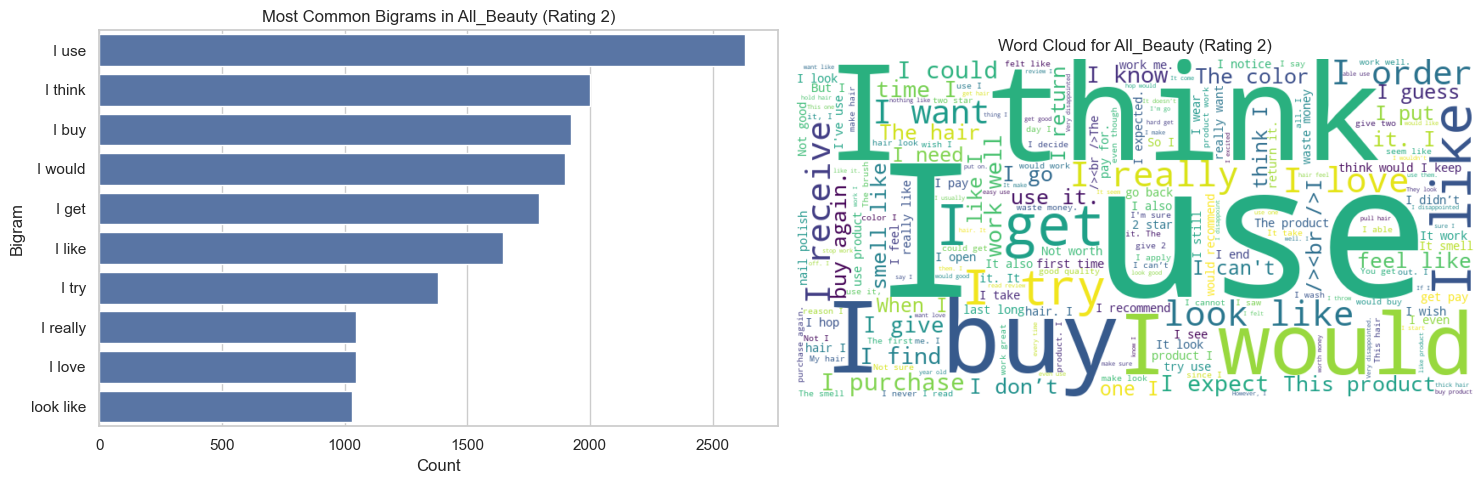

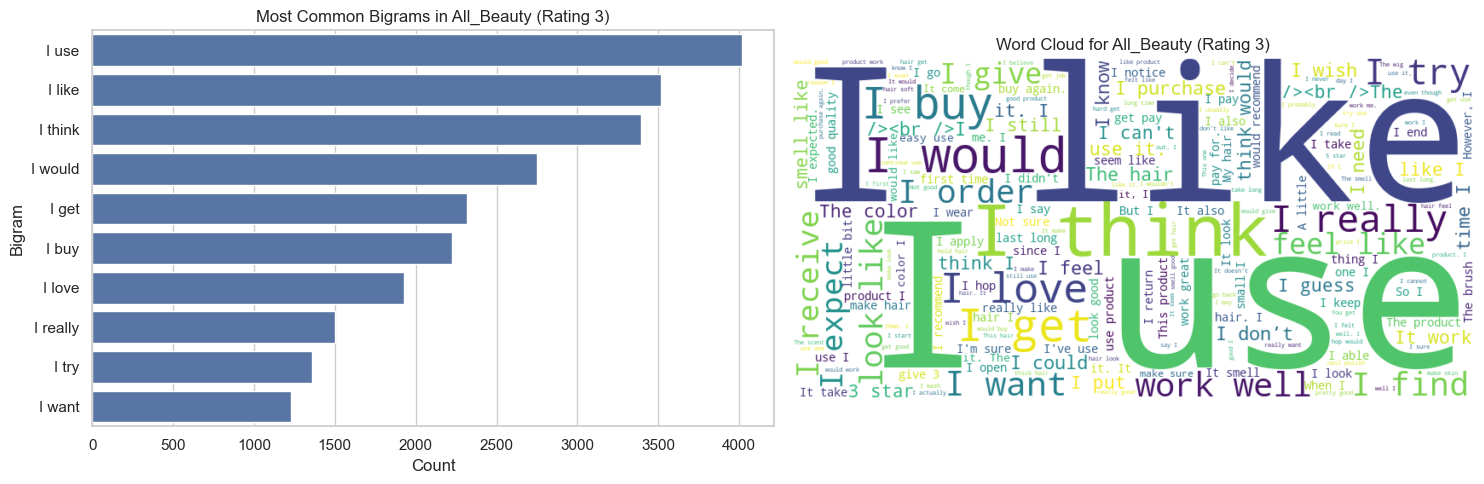

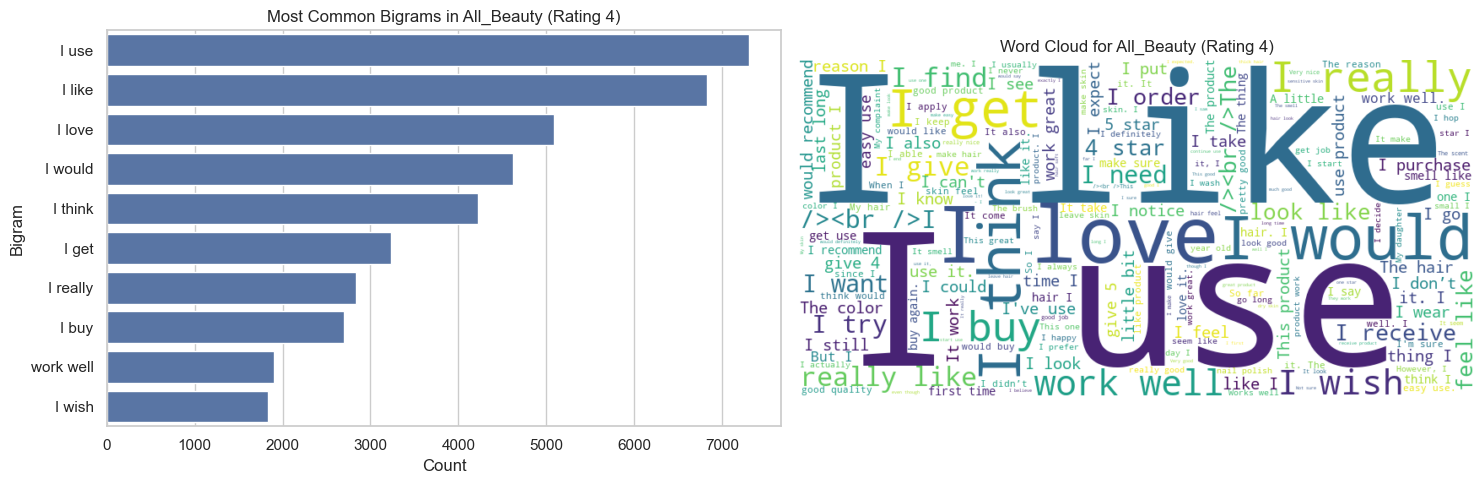

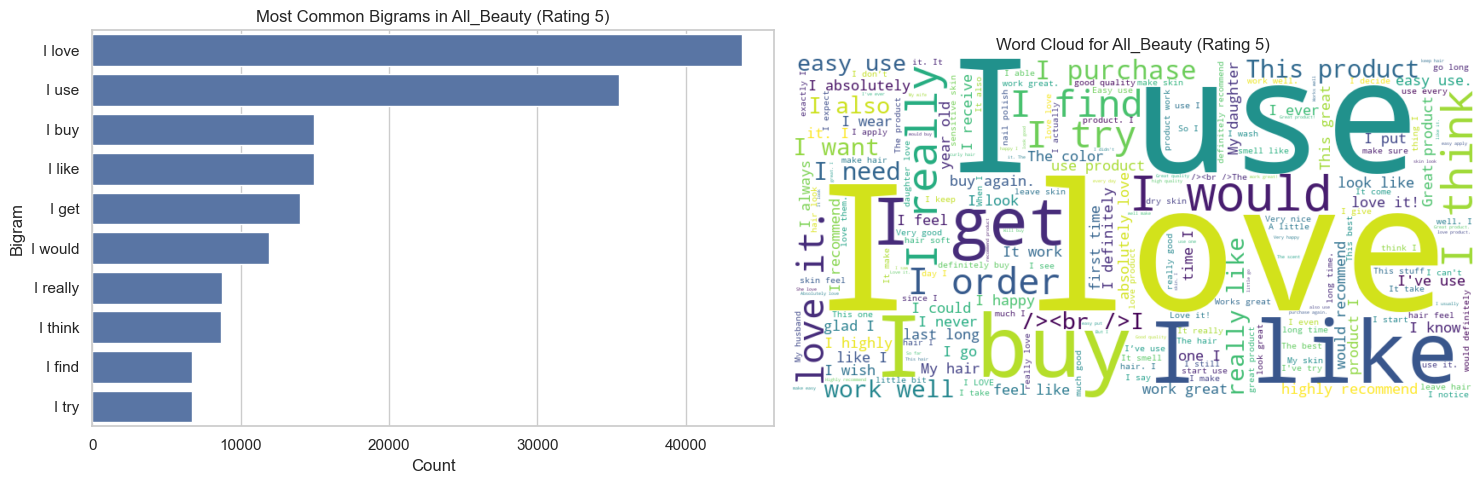

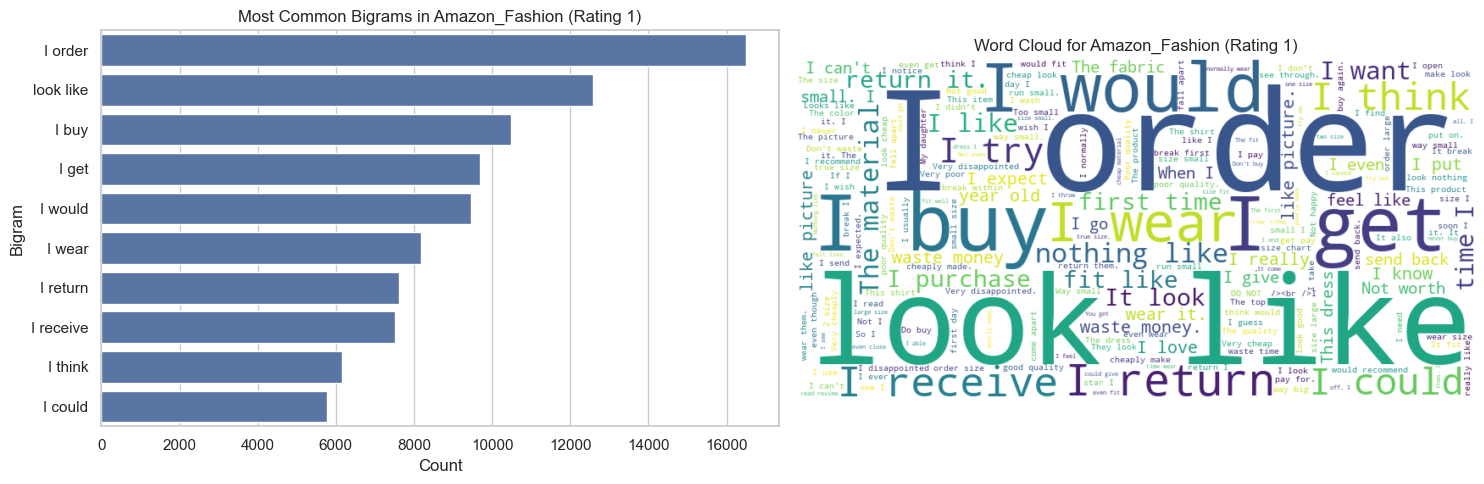

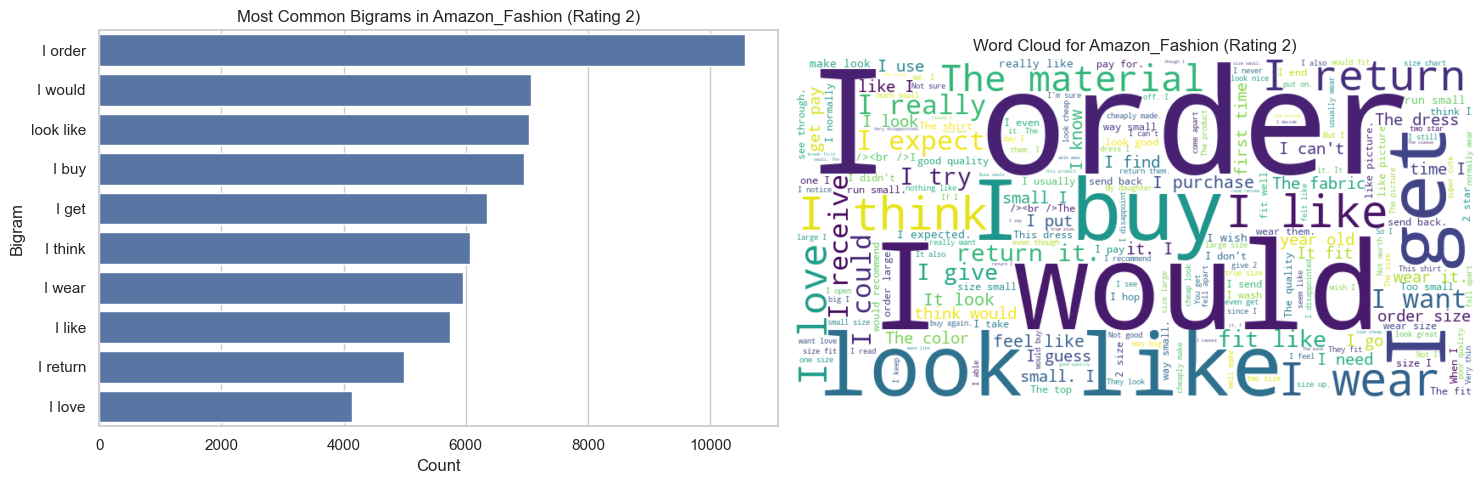

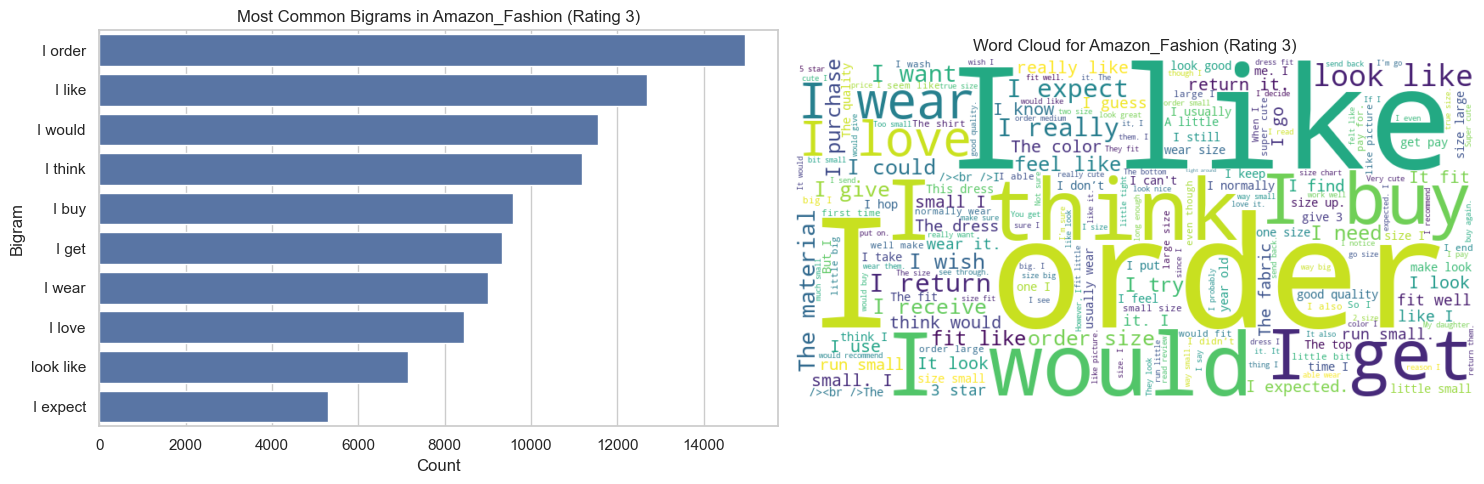

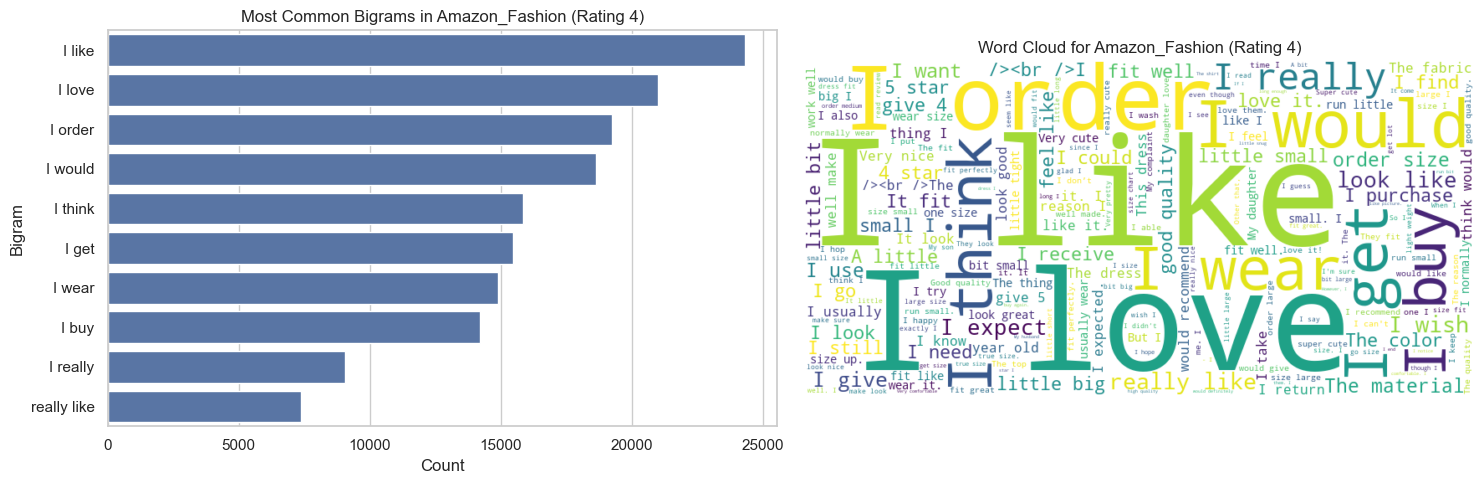

In [ ]:
from nltk.util import ngrams

def generate_bigrams(words):
    bigrams = ngrams(words, 2)
    return [' '.join(bg) for bg in bigrams]


categories = list(set(list(df['cat'].unique())))
ratings = list(set(list(df['rating'].unique())))

for category in categories:
    for rating in ratings:
        subset = df[(df['cat'] == category) & (df['rating'] == rating)]
        all_bigrams = []
        for review_words in subset['text_clean']:
            bigrams = generate_bigrams(review_words)
            all_bigrams.extend(bigrams)
        
        bigram_counts = Counter(all_bigrams)
        common_bigrams = bigram_counts.most_common(10)
        
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Bar Chart
        bigrams, counts = zip(*common_bigrams)
        sns.barplot(x=list(counts), y=list(bigrams), ax=axes[0])
        axes[0].set_title(f'Most Common Bigrams in {category} (Rating {rating})')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Bigram')
        
        # Word Cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_counts)
        axes[1].imshow(wordcloud, interpolation='bilinear')
        axes[1].set_title(f'Word Cloud for {category} (Rating {rating})')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()


In [6]:
df[df.text.str.contains('ice maker')]

rating                                               text  \
19            3  This was hard to find out how to put it into t...   
79            4  There are times when the ice maker on the refr...   
152           5  Our refrigerator didn't come with an ice maker...   
224           5                                 Love my ice maker!   
238           5  OEM ice maker, worked perfectly, arrived quick...   
...         ...                                                ...   
2128388       1  Worst ice maker. Loud and takes a long time to...   
2128390       1  This product worked for about 2 weeks and got ...   
2128568       2  We have tried this product for 3 mths. I would...   
2128577       5  I was somewhat skeptic about this fixing my ic...   
429646        1  You are paying for an ice maker. It is literal...   

                cat  num_characters  num_words  
19       Appliances             256         52  
79       Appliances            1037        200  
152      Appliances             613        120  
224      Appliances              18          4  
238      Appliances              74         13  
...             ...             ...        ...  
2128388  Appliances              56         12  
2128390  Appliances             320         59  
2128568  Appliances             172         34  
2128577  Appliances             234         41  
429646   All_Beauty             284         55  

[38539 rows x 5 columns]

What is the average word length?

In [7]:
print(f"Avg Number of words: {df['num_words'].mean()}")
print("Avg Number of words per Category:")
display(df.groupby(['cat', 'rating']).agg({'num_words':['median','mean', 'size']}).reset_index())

Avg Number of words: 30.00039297912315
Avg Number of words per Category:


cat rating num_words                    
                             median       mean     size
0       All_Beauty      1      20.0  30.641908   102080
1       All_Beauty      2      24.0  37.163592    43034
2       All_Beauty      3      25.0  39.420658    56307
3       All_Beauty      4      25.0  43.044406    79381
4       All_Beauty      5      17.0  30.645087   420726
5   Amazon_Fashion      1      18.0  27.164015   303411
6   Amazon_Fashion      2      22.0  32.781820   173462
7   Amazon_Fashion      3      23.0  33.748630   245471
8   Amazon_Fashion      4      22.0  34.559849   352327
9   Amazon_Fashion      5      13.0  23.917335  1426268
10      Appliances      1      28.0  44.630729   250453
11      Appliances      2      32.0  50.602292    79664
12      Appliances      3      29.0  48.431718   104047
13      Appliances      4      22.0  42.739223   208216
14      Appliances      5      13.0  26.260199  1486225

## LSTM time!

In [19]:
wnl.lemmatize("hanging")

'hanging'

In [ ]:


print(lemmatized_sentence)


[nltk_data] Downloading package punkt_tab to /Users/mrla/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mrla/nltk_data...


['The', 'striped', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
